In [2]:
import pandas as pd
import numpy as np
import math
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# select the style from fivethityeight website
plt.style.use('fivethirtyeight') 
mpl.rcParams['lines.linewidth'] = 2

# predefined figsize
figsize=(20,10)

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [3]:
train = pd.read_csv("../dataset/original/train.csv")
test = pd.read_csv("../dataset/original/x_test.csv")

def convert_date(df):
    df["Unnamed: 0"] = df["Unnamed: 0"].str.split(" ")
    df["Unnamed: 0"] = df["Unnamed: 0"].apply(lambda x: "-".join(x[1:]))
    df = df.rename(columns = {'Unnamed: 0':'Date'})
    df.Date = pd.to_datetime(df.Date)
    return df    

df = pd.concat([train, test])
df = convert_date(df)

train = convert_date(train)
test = convert_date(test)

df = df.sort_values(['sku','Date'])
df = df.reset_index(drop=True)

# Encoding Categorical Features

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df.pack = le.fit_transform(df.pack)
df.brand = le.fit_transform(df.brand)

In [4]:
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(set(df.sku)), replace=False)

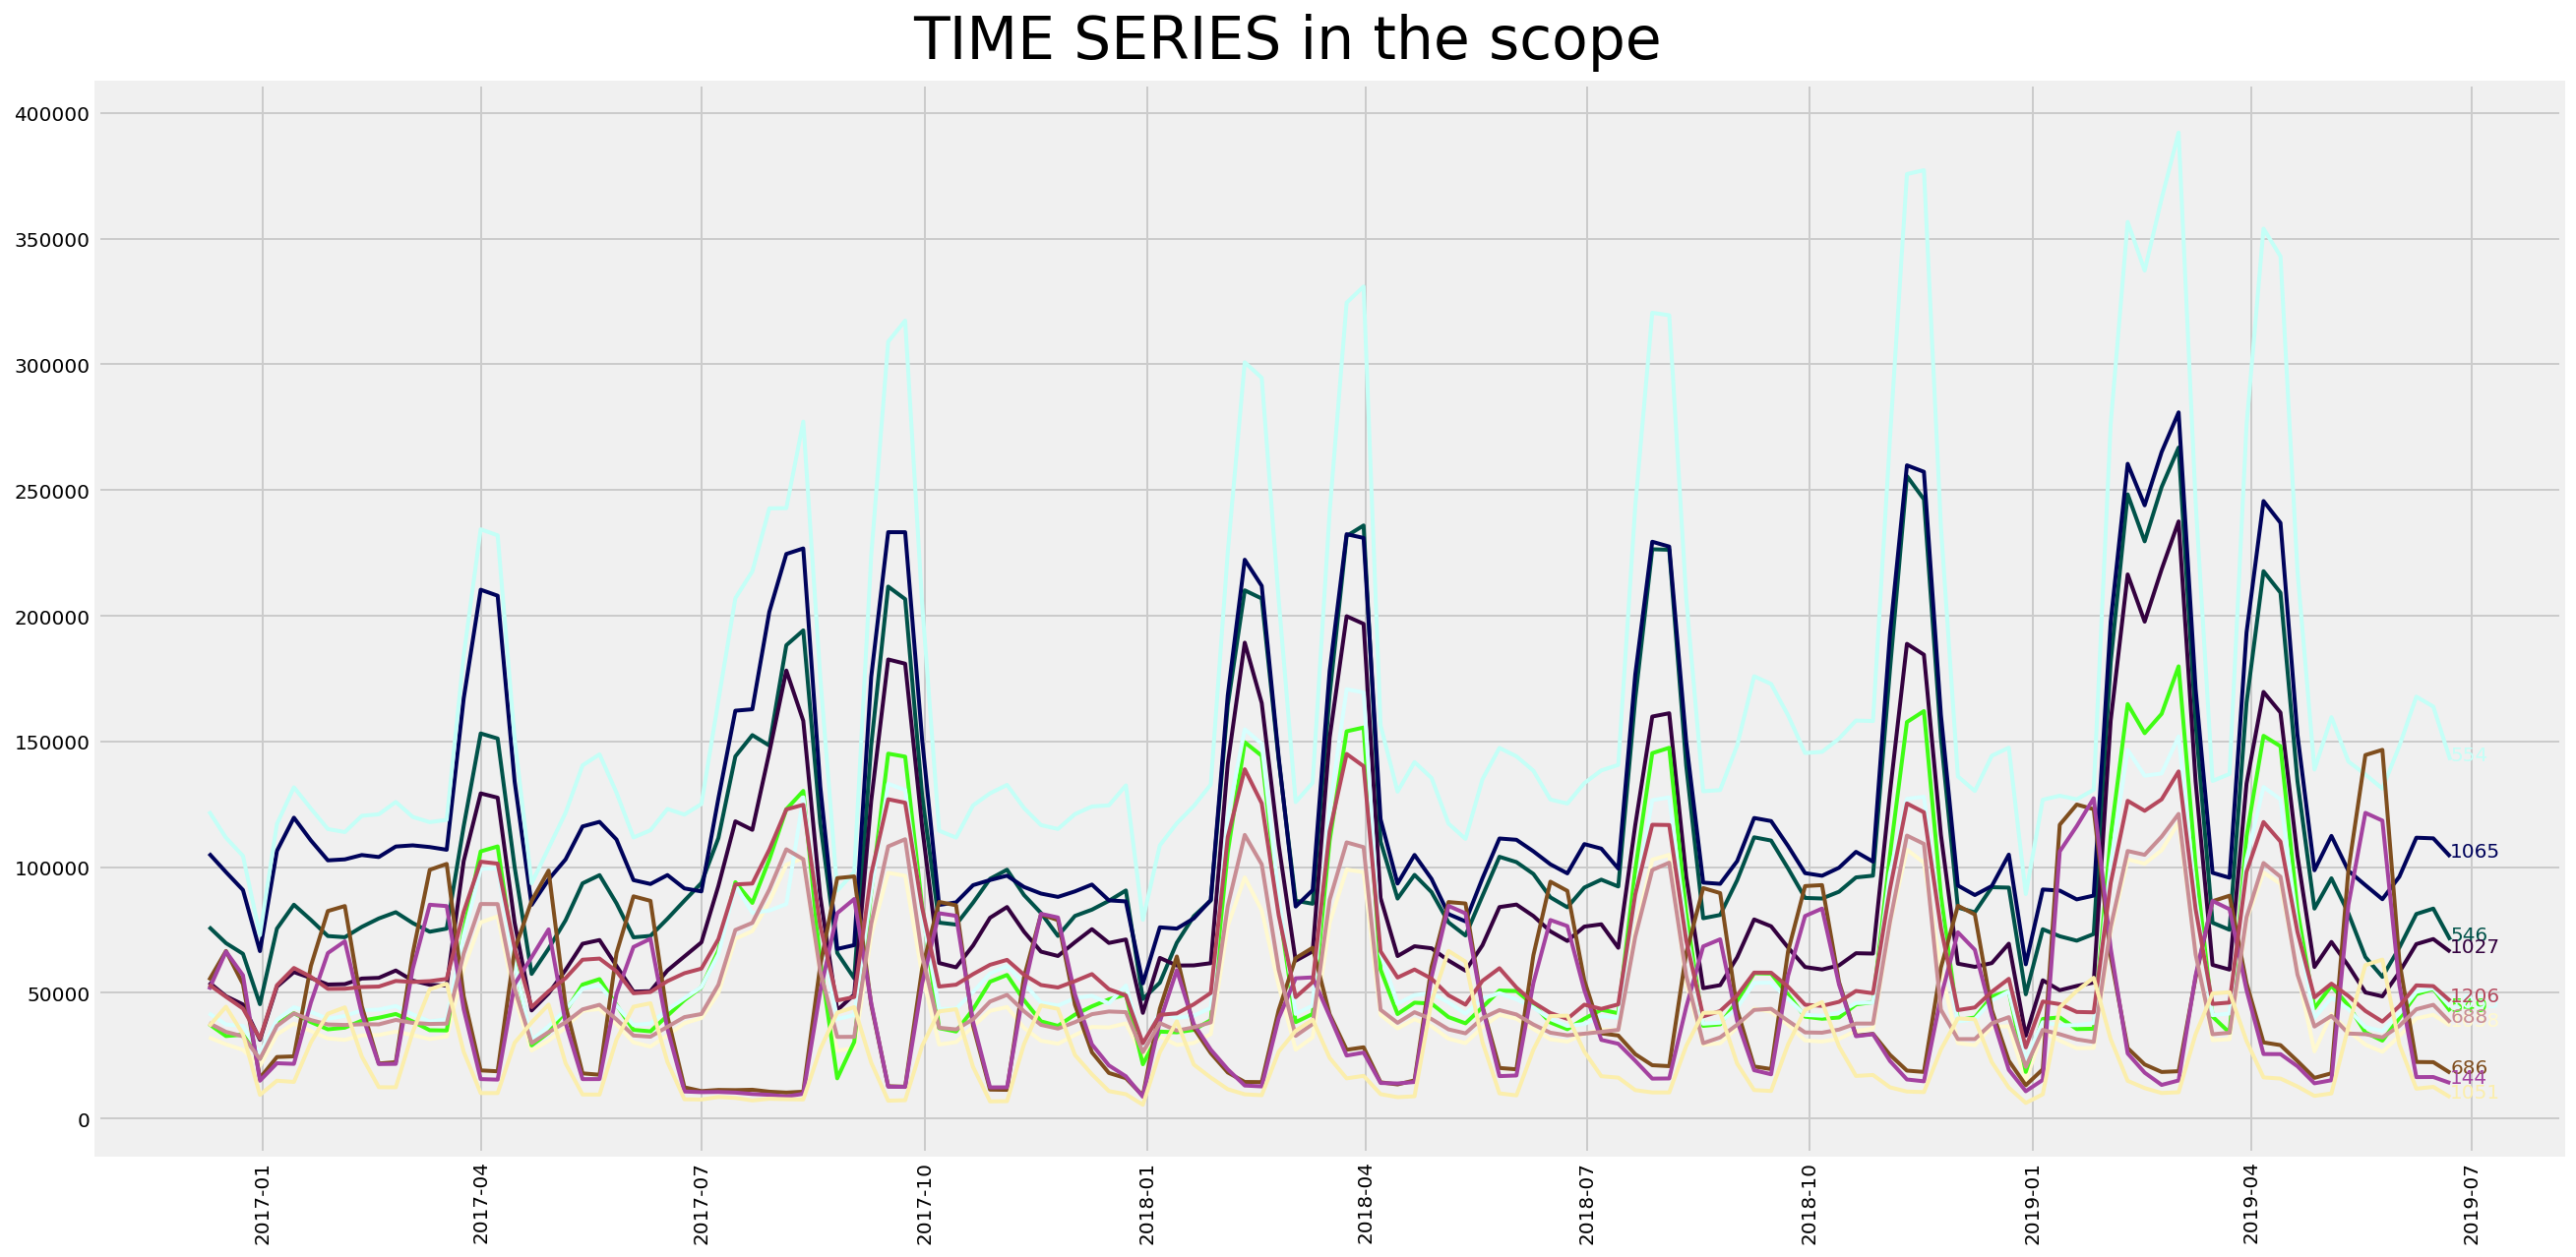

In [5]:
plt.figure(figsize=figsize)
plt.xticks(rotation=90)
plt.suptitle("TIME SERIES in the scope", fontsize=30, y=0.93)

for i,s in enumerate(set(df[df.scope == 1]['sku'])):
    plt.plot(train[train.sku == s].Date, train[train.sku == s].target, color=mycolors[i])
    last_x, last_y = train[train.sku == s].Date.values[-1], train[train.sku == s].target.values[-1]
    plt.text(last_x, last_y, str(s), color=mycolors[i])

## Correlation between timeseries in the scope

In [6]:
from scipy.stats import pearsonr

def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = '\u03C1'
    ax.annotate(f'{rho} = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="Blues",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)
    
    
series_df = pd.DataFrame()
series_df['Date'] = df['Date'].drop_duplicates()
series_df = series_df.sort_values(['Date'])
series_df = series_df.reset_index(drop=True)

for s in sorted(set(df[df.scope == 1]['sku'])):
    series_df[str(s)] = np.array(df[df.sku == s]['sales w-1'])

series_df

Date      144       546       549       554      686       688  \
0   2016-12-10      NaN       NaN       NaN       NaN      NaN       NaN   
1   2016-12-17  51320.0   76232.0   37595.0  122206.0  54995.0   37967.0   
2   2016-12-24  66431.0   69788.0   32822.0  111678.0  66652.0   34485.0   
3   2016-12-31  57001.0   65540.0   33366.0  104479.0  53490.0   32718.0   
4   2017-01-07  15052.0   45488.0   23845.0   72960.0  16100.0   23688.0   
..         ...      ...       ...       ...       ...      ...       ...   
153 2019-11-16  17765.0  184617.0  125244.0  304125.0  23528.0  100710.0   
154 2019-11-23  40594.0  110472.0   68474.0  195966.0  56078.0   56313.0   
155 2019-11-30  57970.0   54079.0   29606.0  118041.0  72004.0   30053.0   
156 2019-12-07  58818.0   55145.0   28557.0  116758.0  69134.0   30378.0   
157 2019-12-14  35888.0   59591.0   32141.0  122006.0  41194.0   32655.0   

         1027      1035     1051     1058      1065      1206  
0         NaN       NaN      NaN      NaN       NaN       NaN  
1     54158.0   41870.0  36721.0  32275.0  105446.0   53301.0  
2     48676.0   37417.0  44502.0  29540.0   98031.0   48441.0  
3     45389.0   36831.0  33581.0  27343.0   90915.0   43767.0  
4     31329.0   25737.0   9425.0  20943.0   66600.0   31760.0  
..        ...       ...      ...      ...       ...       ...  
153  145660.0  122639.0  14155.0  87767.0  208241.0  111353.0  
154   84895.0   70778.0  32870.0  48328.0  123955.0   63359.0  
155   43323.0   35221.0  43650.0  25172.0   71502.0   35238.0  
156   45174.0   35633.0  42545.0  25438.0   72675.0   34242.0  
157   47611.0   38087.0  24597.0  27794.0   79456.0   37889.0  

[158 rows x 13 columns]

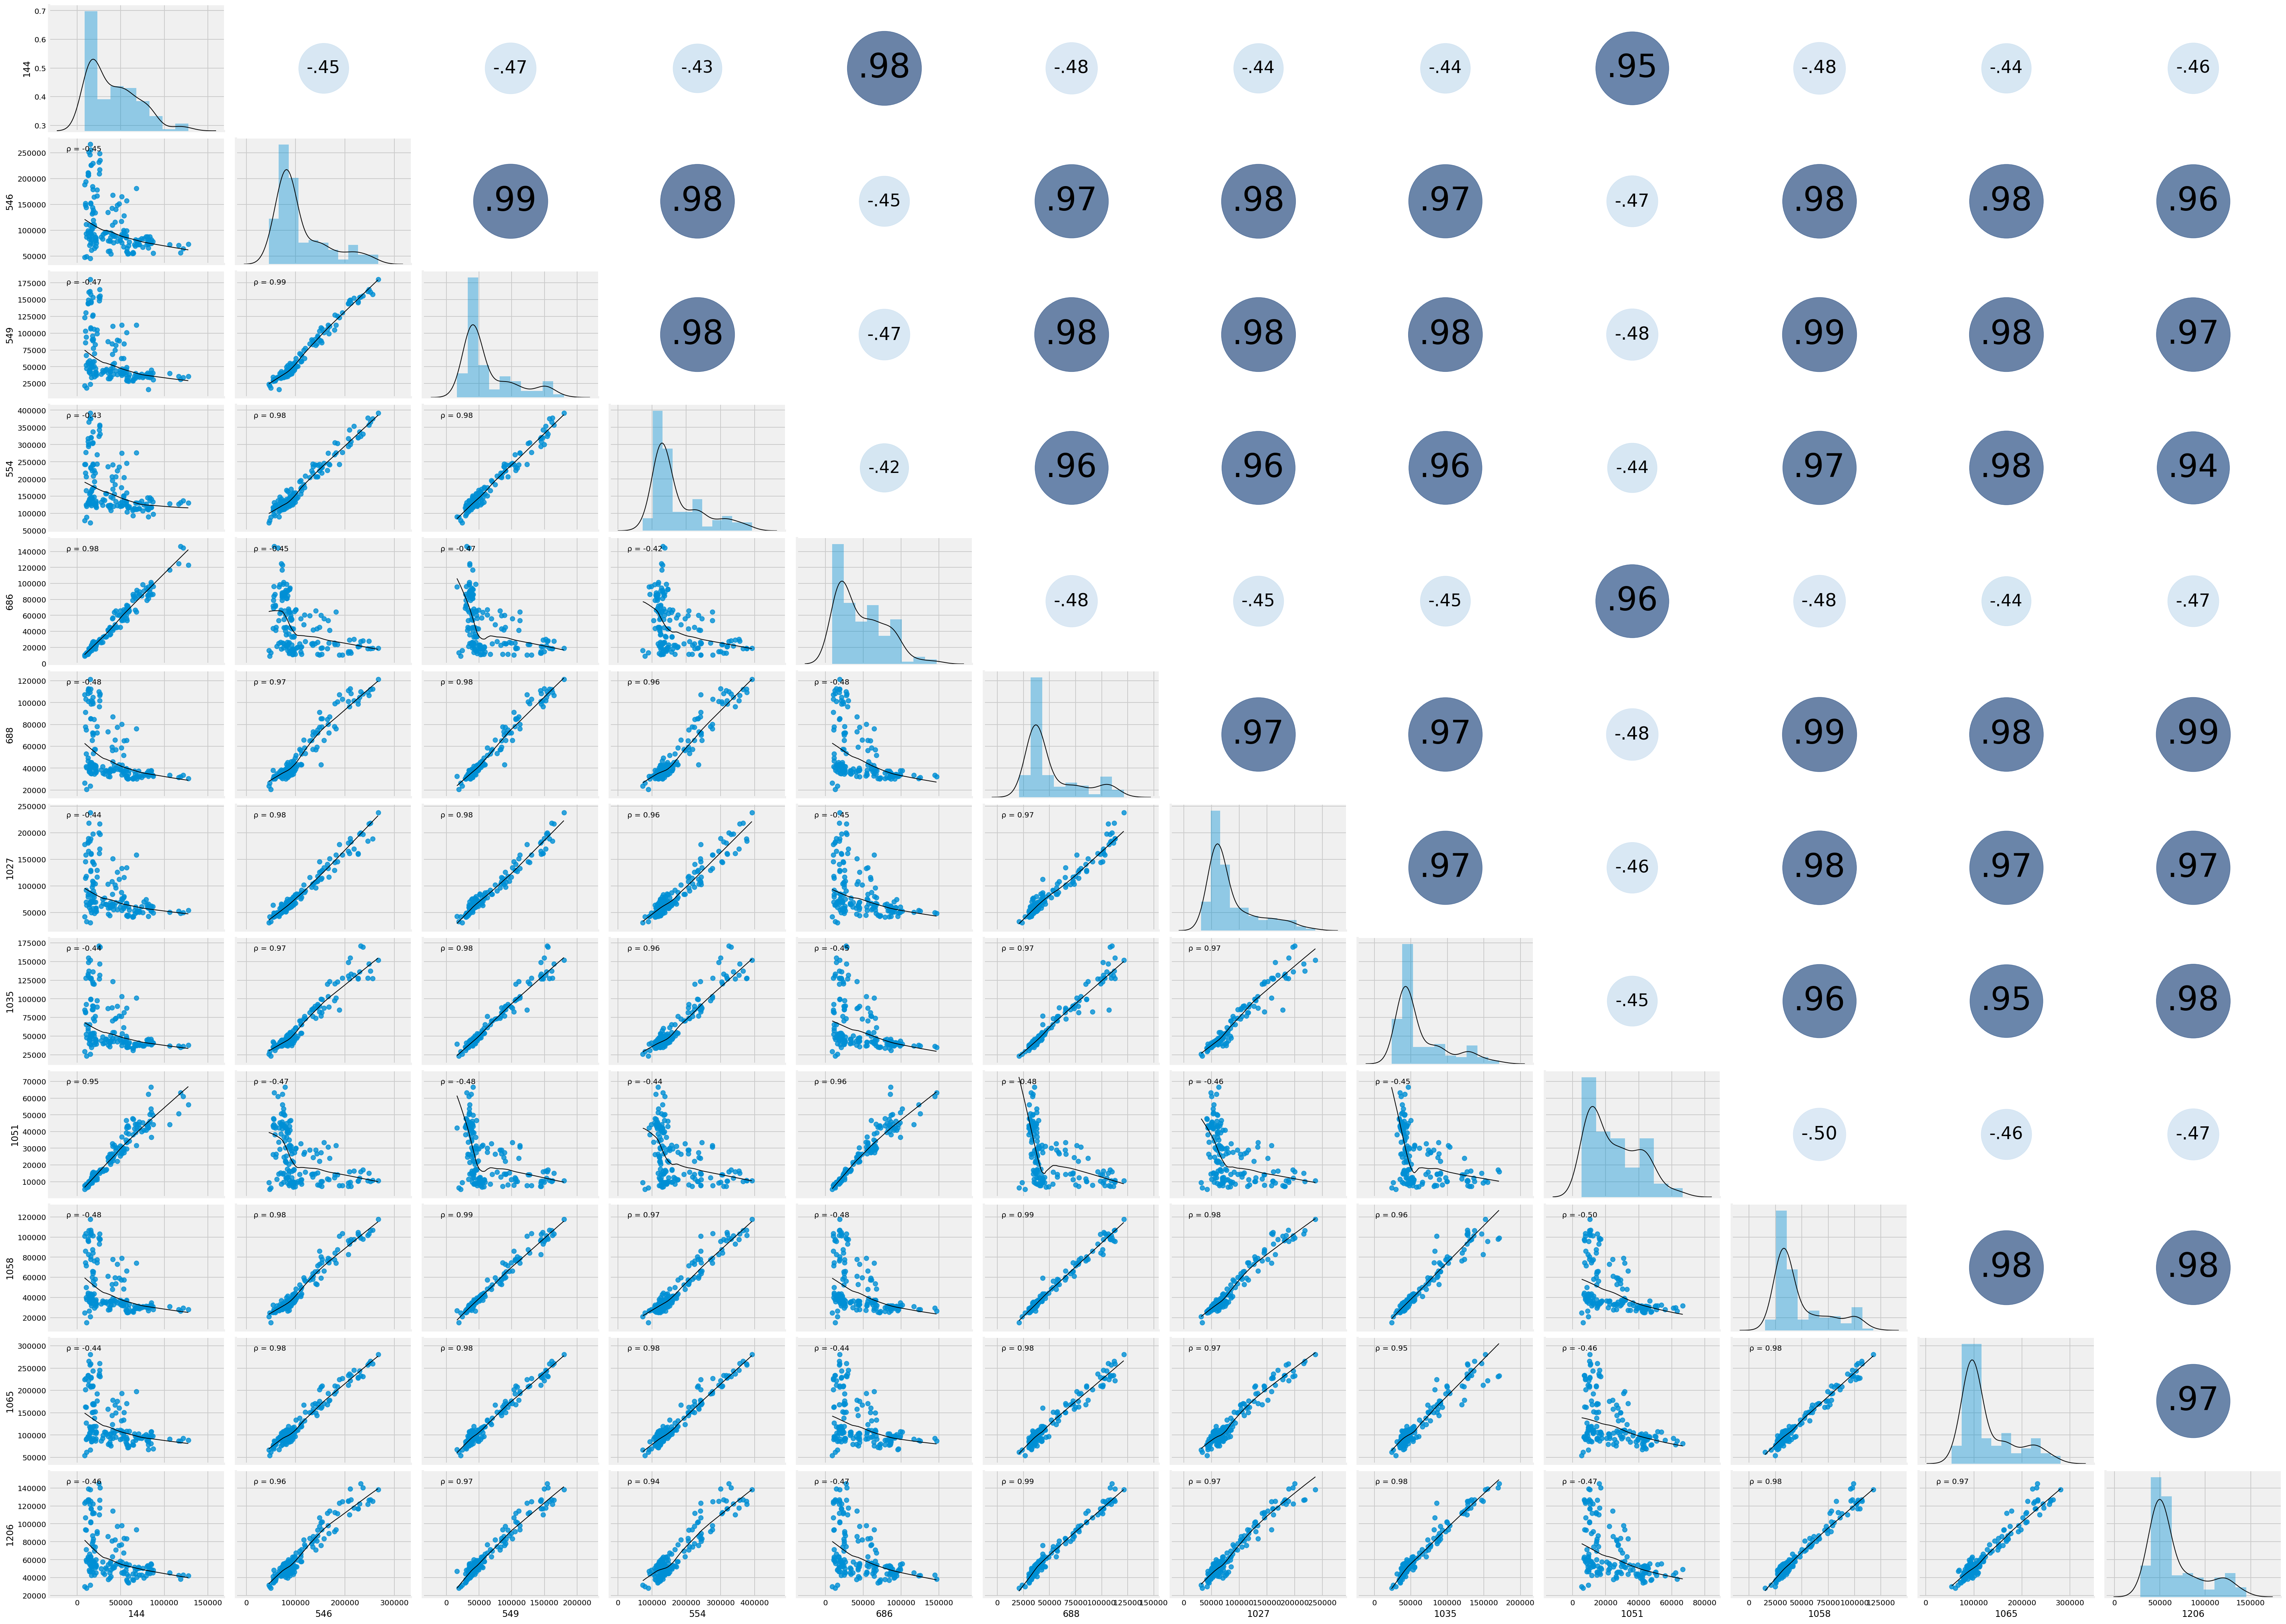

In [7]:
# g = sns.pairplot(stocks,palette=["Blues_d"])
g = sns.PairGrid(series_df, aspect=1.4, diag_sharey=False)
g.map_lower(corrfunc)
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'Black','linewidth':1})
g.map_diag(sns.distplot, kde_kws={'color': 'Black','linewidth':1})
g.map_upper(corrdot)
plt.show()

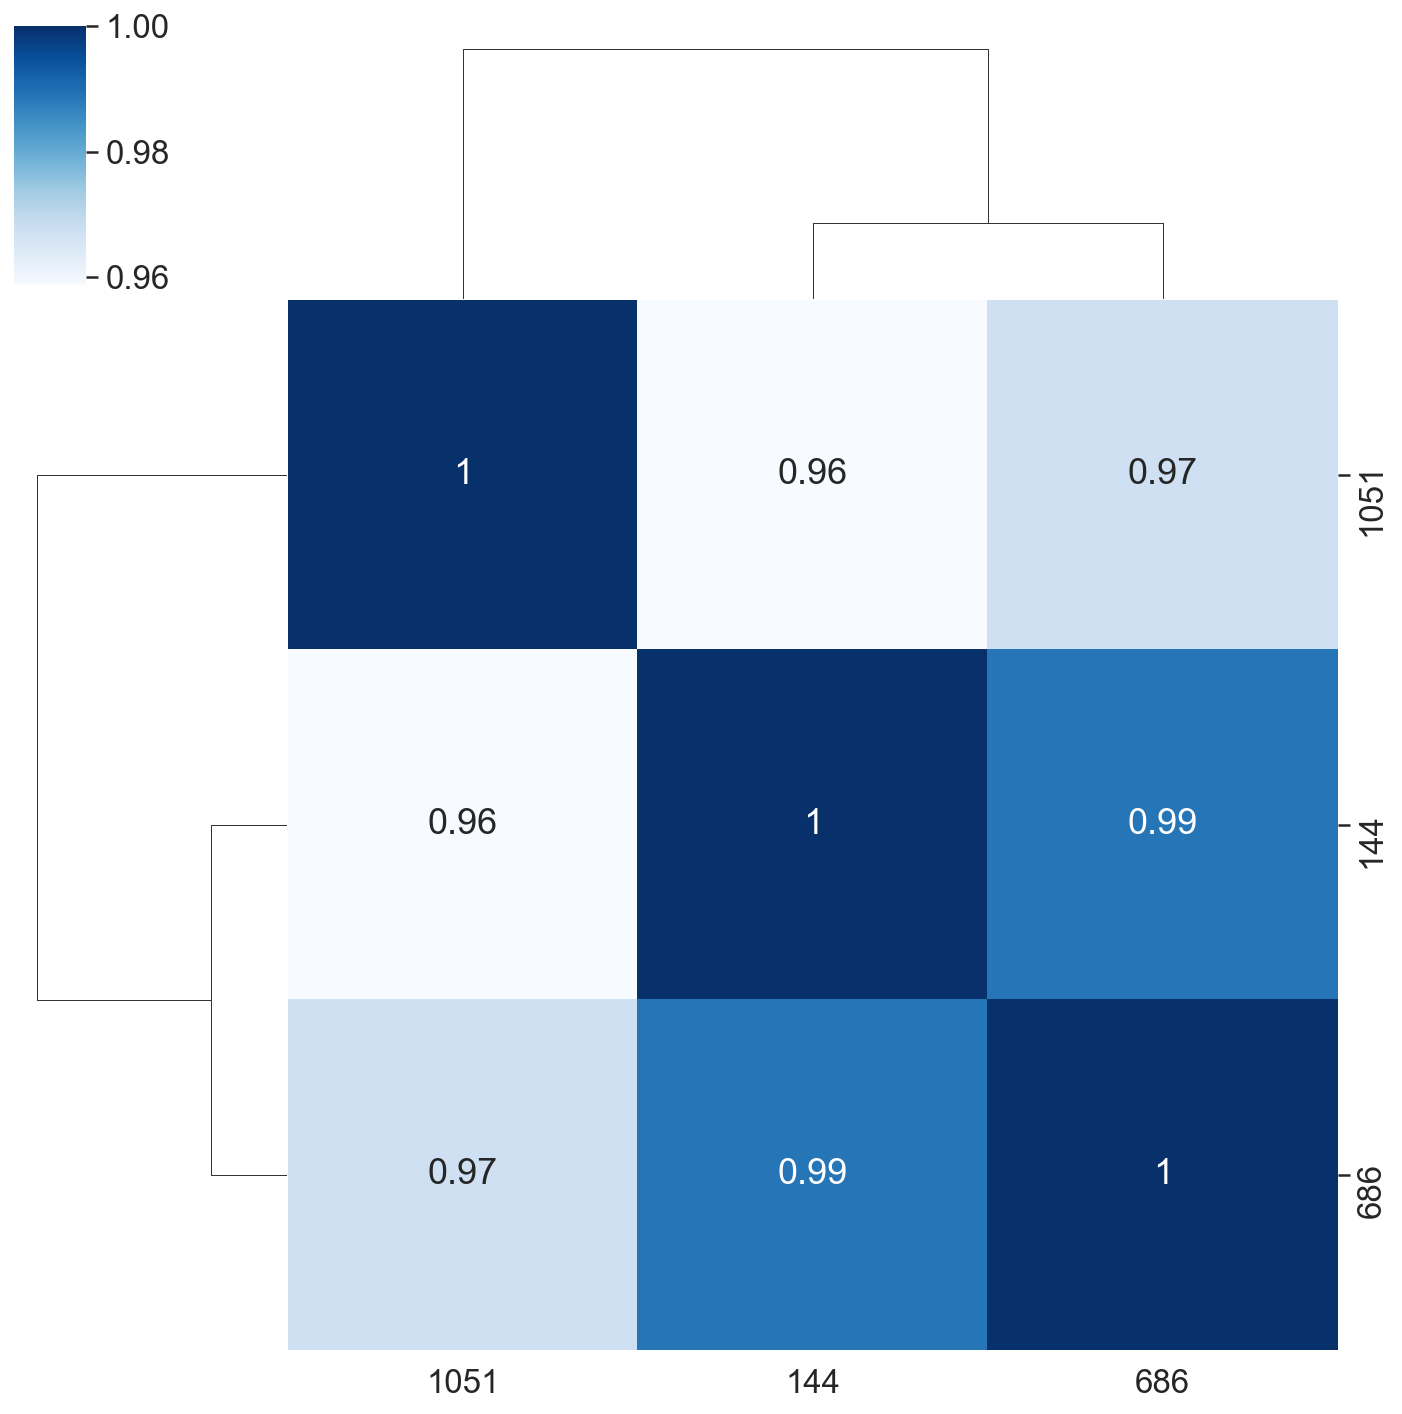

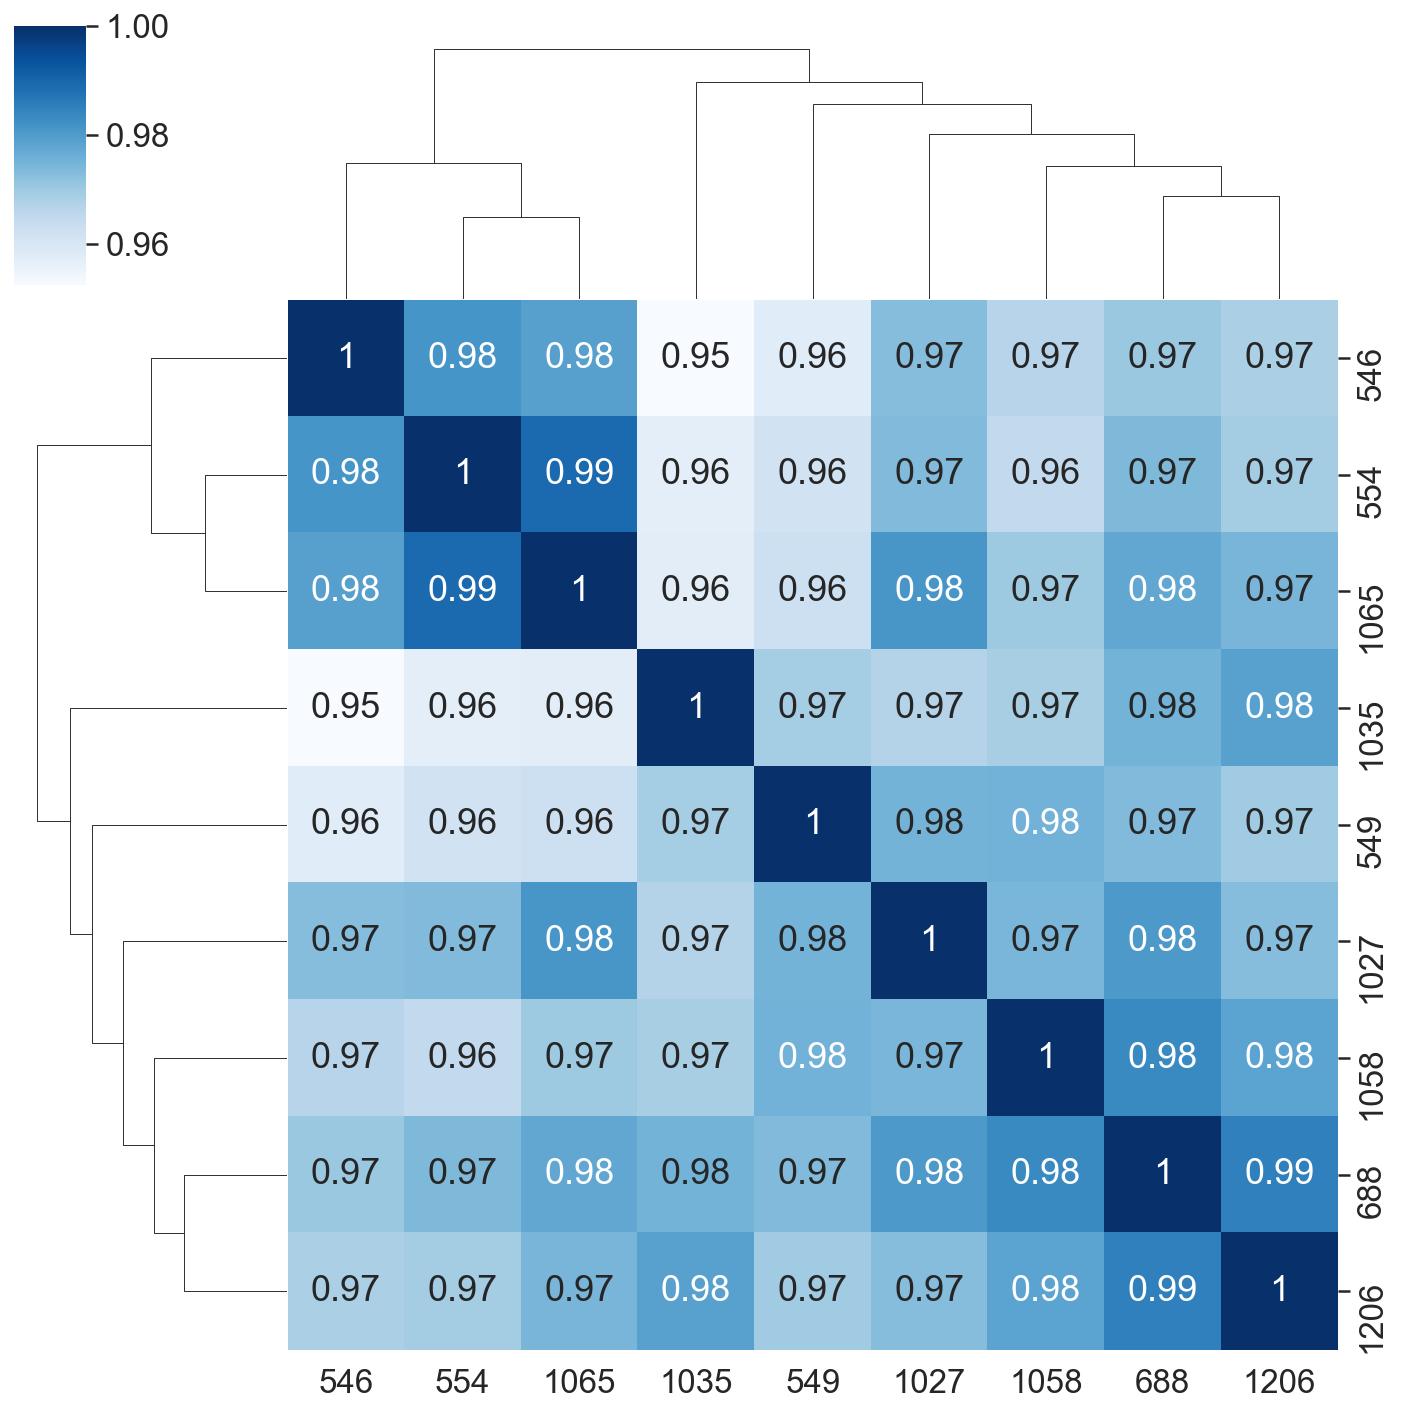

In [8]:
cluster_1 = series_df[['Date', '144', '686', '1051']]
cluster_2 = series_df.drop(columns=['144', '686', '1051'])

weekly_returns_1 = cluster_1.drop(columns=['Date']).pct_change().dropna()
weekly_returns_2 = cluster_2.drop(columns=['Date']).pct_change().dropna()

correlations = weekly_returns_1.corr()
sns.set(font_scale=1.5)
sns.clustermap(correlations, cmap="Blues", annot=True);

correlations = weekly_returns_2.corr()
sns.set(font_scale=1.5)
sns.clustermap(correlations, cmap="Blues", annot=True);

In [9]:
print('------------------------------------------------------------------')
print("-----------------------  CLUSTER 1  ------------------------------")
print('------------------------------------------------------------------')

for i in cluster_1.drop(columns=['Date']).columns:
    print('Autocorrelation of the series of ' + i + ': ' + str(series_df[i].autocorr()))
    print('Autocorrelation of the weekly_returns ' + i + ': ' + str(weekly_returns_1[i].autocorr()))
    print('------------------------------------------------------------------')
    
print('\n')

print('------------------------------------------------------------------')
print("-----------------------  CLUSTER 2  ------------------------------")
print('------------------------------------------------------------------')

for i in cluster_2.drop(columns=['Date']).columns:
    print('Autocorrelation of the series ' + i + ': : ' + str(series_df[i].autocorr()))
    print('Autocorrelation of the weekly_returns ' + i + ': : ' + str(weekly_returns_2[i].autocorr()))
    print('------------------------------------------------------------------')


------------------------------------------------------------------
-----------------------  CLUSTER 1  ------------------------------
------------------------------------------------------------------
Autocorrelation of the series of 144: 0.6339365782661418
Autocorrelation of the weekly_returns 144: 0.11463290233976849
------------------------------------------------------------------
Autocorrelation of the series of 686: 0.6230254087510797
Autocorrelation of the weekly_returns 686: 0.09952686427343406
------------------------------------------------------------------
Autocorrelation of the series of 1051: 0.6128674409612107
Autocorrelation of the weekly_returns 1051: 0.13731614566745182
------------------------------------------------------------------


------------------------------------------------------------------
-----------------------  CLUSTER 2  ------------------------------
------------------------------------------------------------------
Autocorrelation of the series 546

# Hypothesis Test - Are series random walks?

In [10]:
from statsmodels.tsa.stattools import adfuller

print('------------------------------------------------------------------')
print("-----------------------  CLUSTER 1  ------------------------------")
print('------------------------------------------------------------------')
for sku in cluster_1.drop(columns=['Date']).columns:
    adf = adfuller(series_df[sku].dropna())
    print("p-value of " + sku + " sales: %.4f"%adf[1])
    print("-----------------------------------------------")
    
print('\n')

print('------------------------------------------------------------------')
print("-----------------------  CLUSTER 2  ------------------------------")
print('------------------------------------------------------------------')
for sku in cluster_2.drop(columns=['Date']).columns:
    adf = adfuller(series_df[sku].dropna())
    print("p-value of " + sku + " sales: %.4f"%adf[1])
    print("-----------------------------------------------")

------------------------------------------------------------------
-----------------------  CLUSTER 1  ------------------------------
------------------------------------------------------------------
p-value of 144 sales: 0.0000
-----------------------------------------------
p-value of 686 sales: 0.0000
-----------------------------------------------
p-value of 1051 sales: 0.0000
-----------------------------------------------


------------------------------------------------------------------
-----------------------  CLUSTER 2  ------------------------------
------------------------------------------------------------------
p-value of 546 sales: 0.0000
-----------------------------------------------
p-value of 549 sales: 0.0012
-----------------------------------------------
p-value of 554 sales: 0.0016
-----------------------------------------------
p-value of 688 sales: 0.0000
-----------------------------------------------
p-value of 1027 sales: 0.0000
--------------------------

### We can reject with 95% of confidence that series in the scope are not random walk, because their p-value is lower than 0.05.

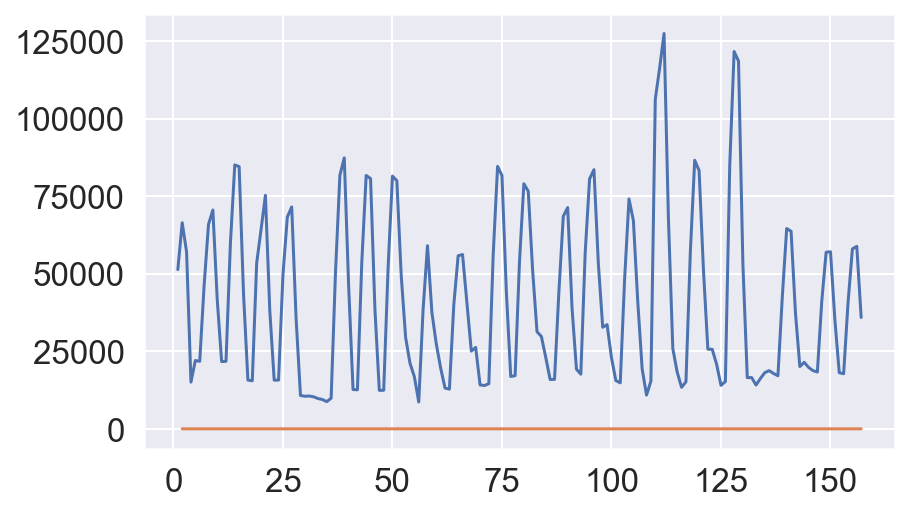

In [11]:
log_144 = np.log(series_df['144'])
plt.plot(series_df['144'], label="Random Walk");
plt.plot(log_144.diff(), label="First Differences");

### Here we have made stationary the series with sku = 144.

In [12]:
ad_fuller_diff_144 = adfuller(series_df['144'].diff().dropna())
ad_fuller_log_144 = adfuller(log_144.dropna())
print ('Diff p-value is: ' + str(ad_fuller_diff_144[1]))
print ('Logarithm p-value is: ' + str(ad_fuller_log_144[1]))

Diff p-value is: 1.5804348442412424e-07
Logarithm p-value is: 6.336283897477098e-21


### Both the series with first difference(1) and logarithm are stationary.  

In [13]:
def create_dict_of_series(df):
    series_dict = {}
    
    for sku in sorted(set(df.sku)):
        single_df = pd.DataFrame()
        single_df['Date'] = df[df.sku == sku]['Date'].drop_duplicates()
        single_df['pack'] = df[df.sku == sku]['pack']
        single_df['size (GM)'] = df[df.sku == sku]['size (GM)']
        single_df['brand'] = df[df.sku == sku]['brand']
        single_df['price'] = df[df.sku == sku]['price']
        single_df['POS_exposed w-1'] = df[df.sku == sku]['POS_exposed w-1']
        single_df['volume_on_promo w-1'] = df[df.sku == sku]['volume_on_promo w-1']
        single_df['sales w-1'] = df[df.sku == sku]['sales w-1']
        single_df['scope'] = df[df.sku == sku]['scope']
        
        if 'target' in df.columns: 
            single_df['target'] = df[df.sku == sku]['target']
        
        single_df = single_df.reset_index(drop = True)
        single_df = single_df.sort_values(['Date'])
        series_dict[sku] = single_df
    
    return series_dict

series_dict = create_dict_of_series(df)
series_dict.keys()

dict_keys([144, 546, 549, 554, 686, 688, 1027, 1035, 1051, 1058, 1065, 1206, 1356, 1365, 1371, 1472, 1516, 1554, 1600, 1603, 1608, 1618, 1633, 1732, 2249, 2360, 2365, 2396, 2401, 2410, 2678, 2681, 2682, 2683, 2689, 2696, 2698, 2704, 2705, 2707, 2711, 2712, 2718])

In [14]:
def dict_in_scope(df_dict):
    series_in_scope_dict = {}

    for key in df_dict.keys():
        if df[df.sku == key].scope.values.all() == 1:
            series_in_scope_dict[key] = df_dict[key]
    
    return series_in_scope_dict

series_in_scope_dict = dict_in_scope(series_dict)

train_dict = dict_in_scope(create_dict_of_series(train))
test_dict = dict_in_scope(create_dict_of_series(test))

# ARIMA model

## Let's start with an autoregressive model.

In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_144 = SARIMAX(train_dict[144]['target'], order=(2,1,2))
result = model_144.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 target   No. Observations:                  133
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -1465.540
Date:                Tue, 02 Jun 2020   AIC                           2941.081
Time:                        10:04:31   BIC                           2955.495
Sample:                             0   HQIC                          2946.938
                                - 133                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0950      0.110      9.937      0.000       0.879       1.311
ar.L2         -0.7355      0.106     -6.910      0.000      -0.944      -0.527
ma.L1         -1.0348      0.156     -6.644      0.000      -1.340      -0.730
ma.L2          0.0693      0.145      0.477      0.634      -0.216       0.354
sigma2      3.265e+08    6.2e-10   5.26e+17      0.000    3.26e+08    3.26e+08
===================================================================================
Ljung-Box (Q):                       49.68   Jarque-Bera (JB):                59.50
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               1.77   Skew:                             1.01
Prob(H) (two-sided):                  0.06   Kurtosis:                         5.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.73e+33. Standard errors may be unstable.
"""

In [16]:
predictions = result.get_prediction(start=-25)
predictions_mean = predictions.predicted_mean
confidence_intervals = predictions.conf_int()
lower_limits = confidence_intervals['lower target']
upper_limits = confidence_intervals['upper target']

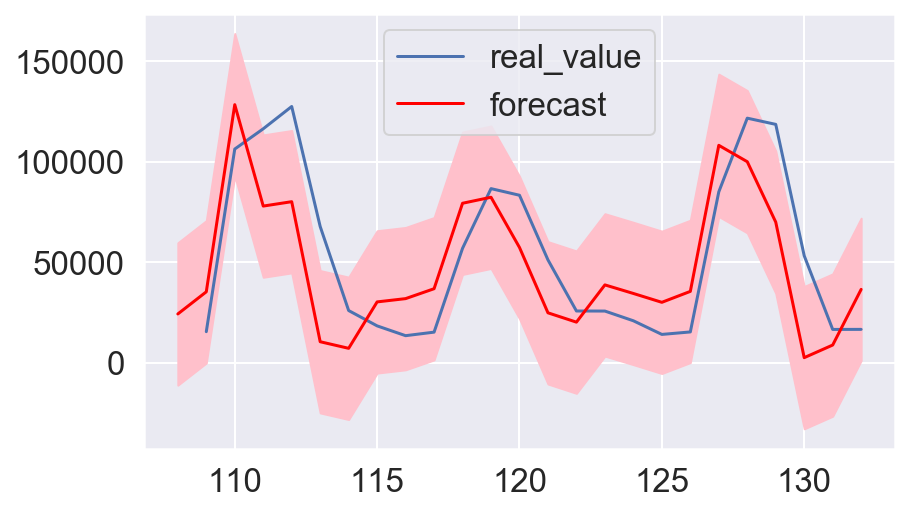

In [17]:
plt.figure()

plt.plot(train_dict[144]['sales w-1'][-24:], label='real_value')
predictions_mean.plot(color='red', label='forecast')

plt.fill_between(predictions_mean.index, lower_limits,upper_limits, color='pink')
plt.legend()
plt.show()

In [22]:
import pmdarima as pm
import sys
from statsmodels.tsa.arima_model import ARIMA

sys.path.append('../')
from metrics.MAPE import MAPE

global_predictions = []
real_values = []

for key in sorted(train_dict.keys()):
    # One different model for each sku
    history = [x for x in train_dict[key]['target']]
    stats_estimated = pm.auto_arima(history)
    real_values.extend(np.array(test_dict[key]['sales w-1'])[1:25].astype(float))
    predictions_single_sku = list()
    print("Predictions for " + str(key) + ": ")
    
    for t in range(len(test_dict[key]) - 1):
        model = SARIMAX(history, order=stats_estimated.order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions_single_sku.append(yhat)
        global_predictions.append(yhat)
        obs = np.array(test_dict[key]['sales w-1'])[t+1].astype(float)
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
    
    print("\n")
    
MAPE(real_values, global_predictions)

Predictions for 144: 
predicted=19109.904463, expected=16228.000000
predicted=20308.072486, expected=18114.000000
predicted=31769.203253, expected=18748.000000
predicted=22040.915048, expected=17833.000000
predicted=23387.896759, expected=17105.000000
predicted=26355.768879, expected=42593.000000
predicted=52726.909722, expected=64551.000000
predicted=68107.659292, expected=63666.000000
predicted=50226.647271, expected=37367.000000
predicted=25647.805002, expected=20068.000000
predicted=22667.442732, expected=21441.000000
predicted=31351.571830, expected=19797.000000
predicted=23723.220718, expected=18759.000000
predicted=23234.423809, expected=18315.000000
predicted=27012.440717, expected=40997.000000
predicted=50723.669721, expected=56931.000000
predicted=59233.754025, expected=57061.000000
predicted=46804.301217, expected=35093.000000
predicted=26956.641756, expected=18062.000000
predicted=19145.957744, expected=17765.000000
predicted=27689.758739, expected=40594.000000
predicted=51

18.495707867085752

In [24]:
error = mean_squared_error(real_values, global_predictions)
print('Test MSE: %.3f' % error)

Test MSE: 242863087.533


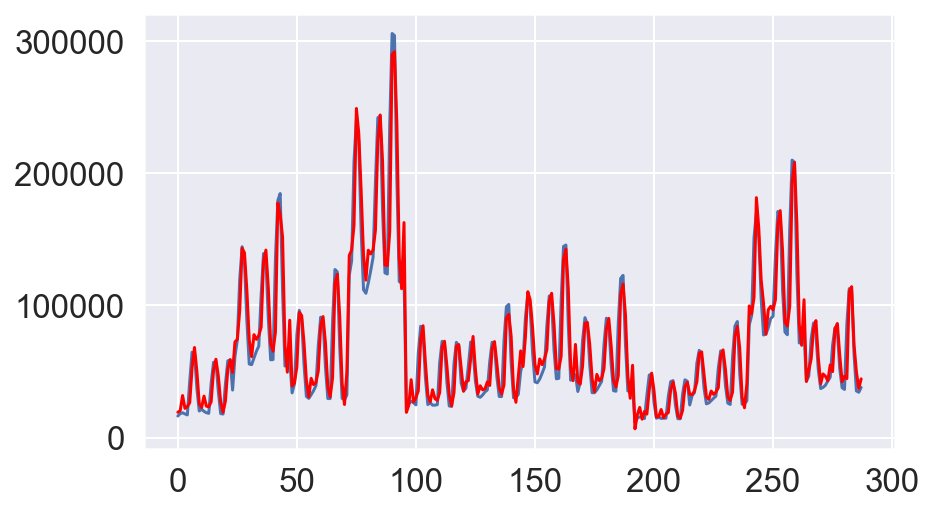

In [25]:
plt.plot(real_values)
plt.plot(global_predictions, color='red')
plt.show()